# Think Bayes: Chapter 9

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [3]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

import sys
import os

In [4]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from thinkbayes2 import Pmf, Cdf, Suite, Joint
import thinkplot

## Improving Reading Ability

From DASL(http://lib.stat.cmu.edu/DASL/Stories/ImprovingReadingAbility.html)

> An educator conducted an experiment to test whether new directed reading activities in the classroom will help elementary school pupils improve some aspects of their reading ability. She arranged for a third grade class of 21 students to follow these activities for an 8-week period. A control classroom of 23 third graders followed the same curriculum without the activities. At the end of the 8 weeks, all students took a Degree of Reading Power (DRP) test, which measures the aspects of reading ability that the treatment is designed to improve.

> Summary statistics on the two groups of children show that the average score of the treatment class was almost ten points higher than the average of the control class. A two-sample t-test is appropriate for testing whether this difference is statistically significant. The t-statistic is 2.31, which is significant at the .05 level.



I'll use Pandas to load the data into a DataFrame.

In [5]:
import pandas as pd

df = pd.read_csv('drp_scores.csv', delimiter='\t')
df.head()

,Treatment,Response
0,Treated,24
1,Treated,43
2,Treated,58
3,Treated,71
4,Treated,43


And use `groupby` to compute the means for the two groups.

In [6]:
grouped = df.groupby('Treatment')
for name, group in grouped:
    print(name, group.Response.mean())

Control 41.5217391304
Treated 51.4761904762


The `Normal` class provides a `Likelihood` function that computes the likelihood of a sample from a normal distribution.

In [7]:
from scipy.stats import norm

class Normal(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        
        data: sequence of test scores
        hypo: mu, sigma
        """
        mu, sigma = hypo
        likes = norm.pdf(data, mu, sigma)
        return np.prod(likes)

The prior distributions for `mu` and `sigma` are uniform.

In [8]:
mus = np.linspace(20, 80, 101)
sigmas = np.linspace(5, 30, 101)

I use `itertools.product` to enumerate all pairs of `mu` and `sigma`.

In [9]:
from itertools import product

control = Normal(product(mus, sigmas))
data = df[df.Treatment=='Control'].Response
control.Update(data)

1.791883192150766e-44

After the update, we can plot the probability of each `mu`-`sigma` pair as a contour plot.

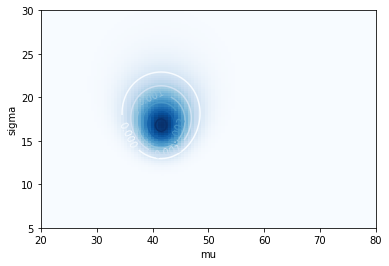

In [10]:
thinkplot.Contour(control, pcolor=True)
thinkplot.Config(xlabel='mu', ylabel='sigma')

And then we can extract the marginal distribution of `mu`

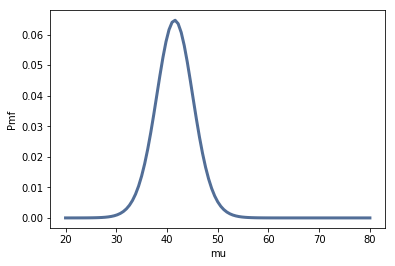

In [11]:
pmf_mu0 = control.Marginal(0)
thinkplot.Pdf(pmf_mu0)
thinkplot.Config(xlabel='mu', ylabel='Pmf')

And the marginal distribution of `sigma`

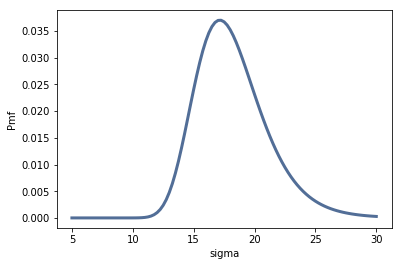

In [12]:
pmf_sigma0 = control.Marginal(1)
thinkplot.Pdf(pmf_sigma0)
thinkplot.Config(xlabel='sigma', ylabel='Pmf')

**Exercise:** Run this analysis again for the `Treated` group.  What is the distribution of the difference between the groups?  What is the probability that the average "reading power" for the treatment group is higher?  What is the probability that the variance of the treatment group is higher?

In [14]:
treated = Normal(product(mus, sigmas))
treated_data = df[df.Treatment=='Treated'].Response
treated.Update(treated_data)

4.5285690956159087e-37

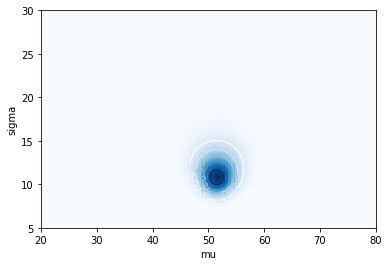

In [24]:
thinkplot.Contour(treated, pcolor=True, label='treated')
thinkplot.Config(xlabel='mu', ylabel='sigma')

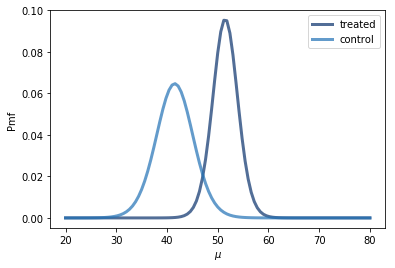

In [25]:
treated_pmf_mu0 = treated.Marginal(0)
thinkplot.Pdf(treated_pmf_mu0, label='treated')
thinkplot.Pdf(pmf_mu0, label='control')
thinkplot.Config(xlabel='$\mu$', ylabel='Pmf')

$\mu$ represents the mean of the test scores; there is a high probability that the treated group will have a higher mean test score. In fact, we can quantify this by considering the central credible interval

In [29]:
treated_pmf_mu0.CredibleInterval(percentage=50), pmf_mu0.CredibleInterval(percentage=50)

((50.0, 53.0), (39.200000000000003, 44.0))

So the treated group has a 50% chance of getting a mean test score between 50 and 53, while the control group had a 50% chance of getting a mean test score between 39.2 and 44.

This is about a 10 point difference in test scores.

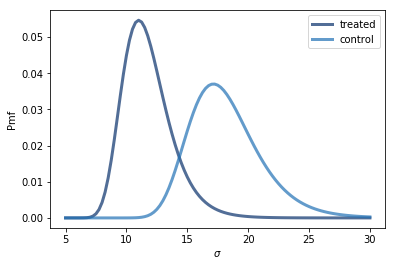

In [30]:
treated_pmf_sigma0 = treated.Marginal(1)
thinkplot.Pdf(treated_pmf_sigma0, label='treated')
thinkplot.Pdf(pmf_sigma0, label='control')
thinkplot.Config(xlabel='$\sigma$', ylabel='Pmf')

$\sigma$ represents the standard deviation of the scores. The treated test is more likely to have a lower standard deviation than the control score, suggesting that the scores are likely to be closer to the mean. 

This indicates that students with below average scores are likely to be pulled up, but also suggest students with above average scores may not be positively affected by the treatment.

**Exercise:** From [John D. Cook](http://www.johndcook.com/blog/2010/07/13/lincoln-index/)

"Suppose you have a tester who finds 20 bugs in your program. You want to estimate how many bugs are really in the program. You know there are at least 20 bugs, and if you have supreme confidence in your tester, you may suppose there are around 20 bugs. But maybe your tester isn't very good. Maybe there are hundreds of bugs. How can you have any idea how many bugs there are? There’s no way to know with one tester. But if you have two testers, you can get a good idea, even if you don’t know how skilled the testers are.

Suppose two testers independently search for bugs. Let k1 be the number of errors the first tester finds and k2 the number of errors the second tester finds. Let c be the number of errors both testers find.  The Lincoln Index estimates the total number of errors as k1 k2 / c [I changed his notation to be consistent with mine]."

So if the first tester finds 20 bugs, the second finds 15, and they find 3 in common, we estimate that there are about 100 bugs.  What is the Bayesian estimate of the number of errors based on this data?

** Solution **

A few definitions:
* My **hypothesis** is the number of bugs in the program
* I have 3 data points: the number of bugs found by the first tester, the number of bugs found by the second tester and the number of bugs found in common. I know nothing about the quality of the testers.

In order to update my likelihood function, I need to be able to describe - given a number of bugs - the likelihood that tester A found 20 bugs, tester B found 15 bugs **and** that 3 of these bugs were overlapping.

The binomial distribution encountered in [chapter 5](../Ch5/chap05.ipynb) may be helpful here; we can define 'success' as tester A finding the same bug as tester B. However, since we are drawing without replacement (once a bug is found, it can't be 'refound', a [hypergeometric distribution](https://en.wikipedia.org/wiki/Hypergeometric_distribution) is more applicable here.

Since I have no idea how many bugs there might be, or the propensity of the programmers to write bugs with code, I'll initialize my hypotheses to 1000 uniform distributions.

In [6]:
from thinkbayes2 import EvalHypergeomPmf

In [36]:
class Bugs(Suite):
    
    def __init__(self, hypos):
        """Initialize the distribution.

        hypos: sequence of hypotheses
        """
        Pmf.__init__(self)
        for hypo in hypos:
            self.Set(hypo, 1)
        self.Normalize()        
    
    def Likelihood(self, data, hypo):
        """
        data: tuple of (testA, testB, overlap)
        hypo: number of bugs, N
        """
        testA, testB, overlap = data
        
        # there can't be less bugs than how many one tester found
        if hypo < max(testA, testB):
            return 0
        
        like = EvalHypergeomPmf(k=overlap, N=hypo, K=testB, n=testA)
        return like

This distribution should be symmetrical (it shouldn't matter if tester A found 20 and test B found 15, or vice versa), so lets plot both to make sure this is the case

In [37]:
bugs = Bugs(range(1, 1000))
bugs_inversed = Bugs(range(1, 1000))

In [38]:
bugs.Update((20, 15, 3))
bugs_inversed.Update((15, 20, 3))

0.048687257035708774

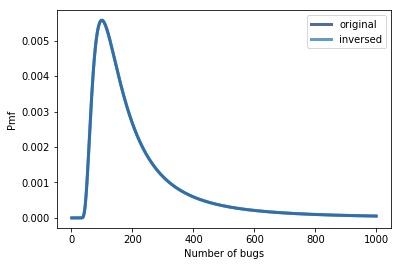

In [39]:
thinkplot.Pdf(bugs, label='original')
thinkplot.Pdf(bugs_inversed, label='inversed')
thinkplot.Config(xlabel='Number of bugs', ylabel='Pmf')

**Exercise:** The GPS problem.  According to [Wikipedia]()

￼
> GPS included a (currently disabled) feature called Selective Availability (SA) that adds intentional, time varying errors of up to 100 meters (328 ft) to the publicly available navigation signals. This was intended to deny an enemy the use of civilian GPS receivers for precision weapon guidance.
> [...]
> Before it was turned off on May 2, 2000, typical SA errors were about 50 m (164 ft) horizontally and about 100 m (328 ft) vertically.[10] Because SA affects every GPS receiver in a given area almost equally, a fixed station with an accurately known position can measure the SA error values and transmit them to the local GPS receivers so they may correct their position fixes. This is called Differential GPS or DGPS. DGPS also corrects for several other important sources of GPS errors, particularly ionospheric delay, so it continues to be widely used even though SA has been turned off. The ineffectiveness of SA in the face of widely available DGPS was a common argument for turning off SA, and this was finally done by order of President Clinton in 2000.

Suppose it is 1 May 2000, and you are standing in a field that is 200m square.  You are holding a GPS unit that indicates that your location is 51m north and 15m west of a known reference point in the middle of the field.

However, you know that each of these coordinates has been perturbed by a "feature" that adds random errors with mean 0 and standard deviation 30m.

1) After taking one measurement, what should you believe about your position?

Note: Since the intentional errors are independent, you could solve this problem independently for X and Y.  But we'll treat it as a two-dimensional problem, partly for practice and partly to see how we could extend the solution to handle dependent errors.

2) Suppose that after one second the GPS updates your position and reports coordinates (48, 90).  What should you believe now?

3) Suppose you take 8 more measurements and get:

    (11.903060613102866, 19.79168669735705)
    (77.10743601503178, 39.87062906535289)
    (80.16596823095534, -12.797927542984425)
    (67.38157493119053, 83.52841028148538)
    (89.43965206875271, 20.52141889230797)
    (58.794021026248245, 30.23054016065644)
    (2.5844401241265302, 51.012041625783766)
    (45.58108994142448, 3.5718287379754585)

At this point, how certain are you about your location?

** Solution ** 

My **hypothesis** is my true location.

My data is the GPS coordinates, which have been perturbed by the random noise.

In [55]:
from scipy.stats import norm

class Gps(Suite, Joint):
    """Represents hypotheses about your location in the field."""
    def __init__(self, verticals, horizontals):
        """Initialize the distribution.
        verticals: possible positions in vertical relation to the reference point
        horizontals: possible positions in horizontal relation to the reference point
        """
        pairs = [(hor, vert) for vert in verticals for hor in horizontals]
        Suite.__init__(self, pairs)   

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: (hor, vert) of true coordinates
        data: (hor, vert) of GPS coordinates
        """
        vert_hypo, hor_hypo = hypo
        vert_gps, hor_gps = data
        
        vert_like = norm.pdf(vert_gps, vert_hypo, 30)
        hor_like = norm.pdf(hor_gps, hor_hypo, 30)
        
        return vert_like * hor_like

In [56]:
verticals = range(-100, 100)
horizontals = range(-100, 100)

gps = Gps(verticals=verticals, horizontals=horizontals)

** 1. My position after one measurement **

Note: for ease of plotting, I have reversed the inputs so that it is horizontal, followed by vertical, distance from the reference point.

In [57]:
gps.Update((-15, 50))

2.3709871650609492e-05

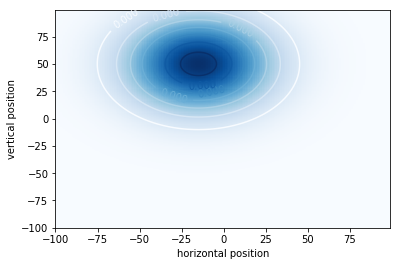

In [58]:
thinkplot.Contour(gps, pcolor=True)
thinkplot.Config(xlabel='horizontal position', ylabel='vertical position')

So after one position, I should believe that I am centered at `(-15, 50)`.

** 2. After a second measurement **

In [59]:
gps.Update((90, 48))

4.3105047948549746e-06

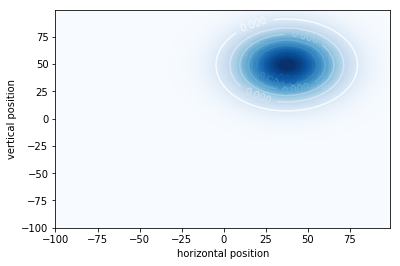

In [60]:
thinkplot.Contour(gps, pcolor=True)
thinkplot.Config(xlabel='horizontal position', ylabel='vertical position')

** 3. After a whole bunch of measurements **

In [61]:
pairs = [(11.903060613102866, 19.79168669735705),
         (77.10743601503178, 39.87062906535289),
         (80.16596823095534, -12.797927542984425),
         (67.38157493119053, 83.52841028148538),
         (89.43965206875271, 20.52141889230797),
         (58.794021026248245, 30.23054016065644),
         (2.5844401241265302, 51.012041625783766),
         (45.58108994142448, 3.5718287379754585)]

In [62]:
gps.UpdateSet(pairs)

6.6969300868770078e-35

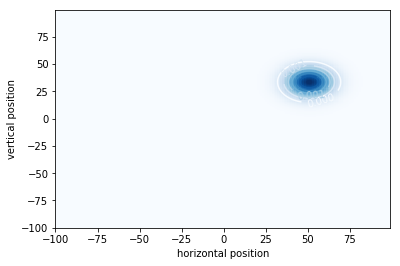

In [63]:
thinkplot.Contour(gps, pcolor=True)
thinkplot.Config(xlabel='horizontal position', ylabel='vertical position')

An interesting note is that the size of the credible intervals has significantly decreased compared to only one measurement, as we become more sure of where we are actually located.

**Exercise:** [The Flea Beetle problem from DASL](http://lib.stat.cmu.edu/DASL/Datafiles/FleaBeetles.html)

Datafile Name: Flea Beetles

Datafile Subjects: Biology

Story Names: Flea Beetles

Reference: Lubischew, A.A. (1962) On the use of discriminant functions in taxonomy. Biometrics, 18, 455-477. Also found in: Hand, D.J., et al. (1994) A Handbook of Small Data Sets, London: Chapman & Hall, 254-255.

Authorization: Contact Authors

Description: Data were collected on the genus of flea beetle Chaetocnema, which contains three species: concinna (Con), heikertingeri (Hei), and heptapotamica (Hep). Measurements were made on the width and angle of the aedeagus of each beetle. The goal of the original study was to form a classification rule to distinguish the three species.

Number of cases: 74

Variable Names:

Width: The maximal width of aedeagus in the forpart (in microns)

Angle: The front angle of the aedeagus (1 unit = 7.5 degrees)

Species: Species of flea beetle from the genus Chaetocnema


Suggestions: 

1. Plot CDFs for the width and angle data, broken down by species, to get a visual sense of whether the normal distribution is a good model.

2. Use the data to estimate the mean and standard deviation for each variable, broken down by species.

3. Given a joint posterior distribution for `mu` and `sigma`, what is the likelihood of a given datum?

4. Write a function that takes a measured width and angle and returns a posterior PMF of species.

5. Use the function to classify each of the specimens in the table and see how many you get right.


In [5]:
import pandas as pd

df = pd.read_csv('flea_beetles.csv', delimiter='\t')
df.head()

,Width,Angle,Species
0,150,15,Con
1,147,13,Con
2,144,14,Con
3,144,16,Con
4,153,13,Con


** 1. Plot CDFs for width and angle **

In [6]:
from thinkbayes2 import _DictWrapper

In [7]:
species_dicts = {}
for species in df.Species.unique():
    relevant_df = df[df.Species == species]
    width_cdf = _DictWrapper(obj=relevant_df.Width).MakeCdf(label=species)
    angle_cdf = _DictWrapper(obj=relevant_df.Angle).MakeCdf(label=species)
    species_dicts[species] = {}
    species_dicts[species]['width'] = width_cdf
    species_dicts[species]['angle'] = angle_cdf

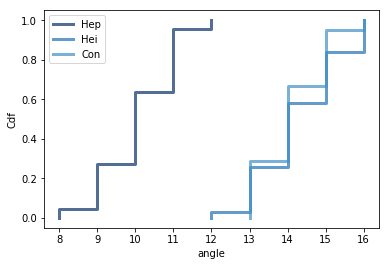

In [8]:
for species in species_dicts:
    thinkplot.Cdf(species_dicts[species]['angle'])
thinkplot.Config(xlabel='angle', ylabel='Cdf')

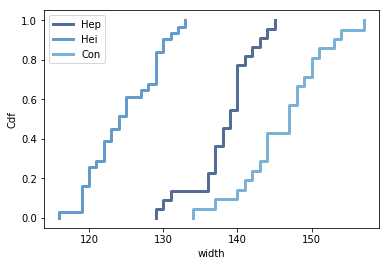

In [9]:
for species in species_dicts:
    thinkplot.Cdf(species_dicts[species]['width'])
thinkplot.Config(xlabel='width', ylabel='Cdf')

These visually look like they can reasonably be approximated by normal distributions.

** 2. Use the data to estimate the mean and standard deviation for each variable, broken down by species.**

This is effectively the same exercise as above; for a given mean and standard distribution, how likely is it that we would have seen the data we did?

In [10]:
from scipy.stats import norm

class Normal(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        
        data: sequence of test scores
        hypo: mu, sigma
        """
        mu, sigma = hypo
        likes = norm.pdf(data, mu, sigma)
        return np.prod(likes)

In [11]:
from itertools import product

species_normals = {}

for species in df.Species.unique():
    relevant_df = df[df.Species == species]
    
    species_normals[species] = {}
    for variable in ['Width', 'Angle']:
        if variable == 'Width':
            mus = np.linspace(110, 160, 121)
            sigmas = np.linspace(1, 30, 101)
        elif variable == 'Angle':
            mus = np.linspace(5, 20, 31)
            sigmas = np.linspace(1, 10, 10)
        data = relevant_df[variable]
        
        distribution = Normal(product(mus, sigmas))
        distribution.Update(data)
        species_normals[species][variable] = distribution

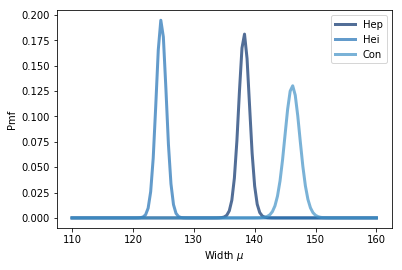

In [12]:
for species in species_normals:
    width = species_normals[species]['Width'].Marginal(0)
    thinkplot.Pdf(width, label=species)
thinkplot.Config(xlabel='Width $\mu$', ylabel='Pmf')

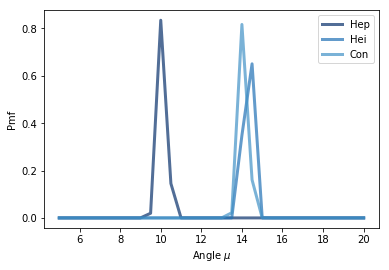

In [13]:
for species in species_normals:
    width = species_normals[species]['Angle'].Marginal(0)
    thinkplot.Pdf(width, label=species)
thinkplot.Config(xlabel='Angle $\mu$', ylabel='Pmf')

We could plot the countour plot for each normal distribution ($\mu$s and $\sigma$s), but in the interest of not having 6 plots, I'll just show it for `Hep`

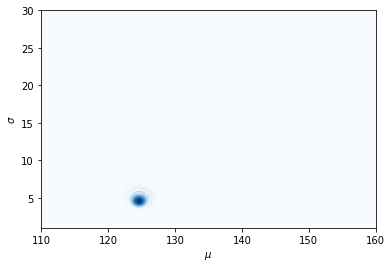

In [14]:
thinkplot.Contour(species_normals['Hei']['Width'], pcolor=True)
thinkplot.Config(xlabel='$\mu$', ylabel='$\sigma$')

** 3. Given a joint posterior distribution for $\mu$ and $\sigma$, what is the likelihood of a given datum? **

This is actually relatively easy; its the sum of the probability of the datum for each hypothesis. For instance, if I see an aedegus of `width=130 microns` and `angle=10 units`, then
\begin{equation}
\textrm{probability} = \textrm{width probability} \times \textrm{angle probability}
\end{equation}

In [15]:
width = 125
angle = 14

# first, find width_probability
width_proba = 0
for data, prob in species_normals['Hei']['Width'].Items():
    mu, sigma = data
    width_proba += (norm.pdf(width, mu, sigma) * prob)
print ('{} % probability of seeing this width'.format(width_proba*100))

# then, find angle_probability
angle_proba = 0
for data, prob in species_normals['Hei']['Angle'].Items():
    mu, sigma = data
    angle_proba += (norm.pdf(angle, mu, sigma)  * prob)
print ('{} % probability of seeing this angle'.format(angle_proba*100))

# Finally, multiply them together
print ('{} % probability overall'.format(width_proba * angle_proba * 100))

8.25601792292 % probability of seeing this width
36.8182983297 % probability of seeing this angle
3.03972530901 % probability overall


** 4. Write a function that takes a measured width and angle and returns a posterior PMF of species. **

In [16]:
def find_species(datum, species_normals, probs=True):
    width, angle = datum
    species_proba = {}
    
    for species in species_normals:
        # first, find width_probability
        width_proba = 0
        for data, prob in species_normals[species]['Width'].Items():
            mu, sigma = data
            width_proba += (norm.pdf(width, mu, sigma) * prob)

        # then, find angle_probability
        angle_proba = 0
        for data, prob in species_normals[species]['Angle'].Items():
            mu, sigma = data
            angle_proba += (norm.pdf(angle, mu, sigma)  * prob)

        # Finally, multiply them together
        total_proba = width_proba * angle_proba
        species_proba[species] = total_proba
    if probs:
        return species_proba
    else:
        # finds the key which had the highest value (in this case, probability)
        return max(species_proba.keys(), key=(lambda spec: species_proba[spec]))

In [19]:
find_species((width, angle), species_normals, probs=False)

'Hei'

So for these two datapoints, our posterior distributions suggest this is a heikertingeri species of beatle.

**5. Use the function to classify each of the specimens in the table and see how many you get right.**

In [20]:
def find_species_wrapper(row):
    return find_species((row.Width, row.Angle), species_normals, probs=False)

In [21]:
df['Bayesian Classification'] = df.apply(find_species_wrapper, axis=1)

In [22]:
df.head()

,Width,Angle,Species,Bayesian Classification
0,150,15,Con,Con
1,147,13,Con,Con
2,144,14,Con,Con
3,144,16,Con,Con
4,153,13,Con,Con


Now, to crudely see how well we did, we can calculate the accuracy of our classifications.

In [24]:
len(df[df['Species'] == df['Bayesian Classification']]) / len(df)

0.9864864864864865

Not too bad!